# Stochastic Block Model with Poisson/Gamma observations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# load nodes and edges from file
nodes = pd.read_csv('./data/got-s6-nodes.csv')
edges = pd.read_csv('./data/got-s6-edges.csv')

# initialize networkx graph object and add nodes and edges
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

In [9]:
model_code="""
data {
        int<lower=1> N; // number of nodes
        int X[N,N]; // adjacency matrix
        int<lower=2> K; // number of groups
        vector[K] alpha; // prior for dirichlet distribution
        real a;          // priors on lambda
        real b;
} parameters {
        //int z[N]; // group belonging, encoded as integers - we cannot do this as z is integer latent variable!
        simplex[K] pi; // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups

} model {
        matrix[K,K] log_mix_prop; // log mixing proportions
        matrix[K,K] lps;
        
        pi ~ dirichlet(alpha); // prior on group sizes
        for (k in 1:K) lambda[k,:] ~ gamma(a,b);
        
        // cache mixing proportions
        for (k1 in 1:K) {
            for (k2 in 1:K) {
                log_mix_prop[k1, k2] = log(pi[k1]) + log(pi[k2]);
            }
        }
        
        // likelihood
        for (i in 1:N) {
            for (j in 1:N) {
                if (i == j) continue; // ignore diagonal
                
                lps = log_mix_prop; // reset log probs
                for (k1 in 1:K) {
                    for (k2 in 1:K) {
                        lps[k1, k2] += poisson_lpmf(X[i,j] | lambda[k1,k2]);
                    }
                    
                    target += log_sum_exp(lps);
                }
            }
        }
        
        
}
"""

In [10]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26debc406d7a86b72ca168d755dc86ce NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpuwnq5iu4/stanfit4anon_model_26debc406d7a86b72ca168d755dc86ce_7771916294175843263.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


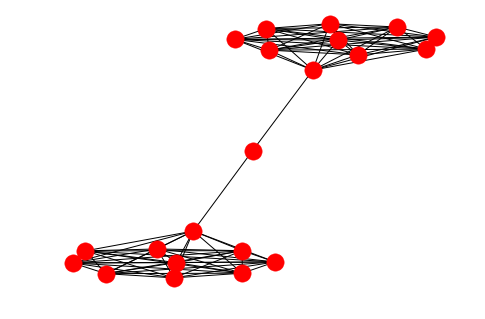

In [13]:
# Generate small network to test on

G = nx.barbell_graph(10,1)
nx.draw(G)